### 운송 최적화

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [3]:
df_tc = pd.read_csv('trans_cost.csv', index_col="공장") # 운송 비용
df_tc.head()

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [4]:
df_demand = pd.read_csv('demand.csv') # 공장의 최소수요
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [5]:
df_supply = pd.read_csv('supply.csv') # 창고의 최대 공급량
df_supply.head()

,W1,W2,W3
0,35,41,42


In [6]:
# 데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")
df_tc.head()
df_demand = pd.read_csv('demand.csv')
df_demand.head()
df_supply = pd.read_csv('supply.csv')

# 초기 설정
np.random.seed(1)
nw = len(df_tc.index) # 창고 개수 : 3
nf = len(df_tc.columns) # 공장 개수 : 4
pr = list(product(range(nw), range(nf))) # product함수는 W(0~2)와 F(0~3)넘버를 중복없이 짝지음 (0,0)~(2,3)

#수리 모델 작성
m1 = model_min() # 최소화를 실행하는 모델, 정의하는 목적함수를 제약 조건 하에서 최소화 가능
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw): # 창고별 총 공급량 최대 공급량
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf): # 공장별 총 수요량 공장에서 필요하는 최소수요
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
# 공장이 제조할 제품 수요량을 만족시키고 창고가 제공할 부품이 제공 한계를 넘지않도록 제약 조건
m1.solve()

# 총 운송 비용 계산, 최적해(운송비용 최소하는 운송량), 최적값 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x) # 구해진 최적해(v1)
    total_cost += df_tc.iloc[i][j]*value(x) # 최적화 이후 총 비용값(원래비용 * 최적해(v1) = 최적값)
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))


    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


### 최적의 운송 경로를 네트워크 가시화

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


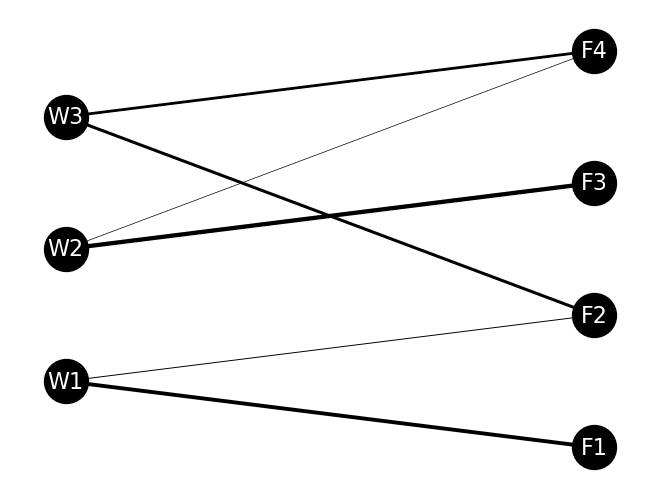

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')
display(df_tr, df_pos)
# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 & 엣지의 가중치 리스트화
for i in range(0, 3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j]) # W - F 를 하나씩 다 연결

# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i] # 0:W1, 1:W2, 2:W3... 6:F4
    pos[node] = (df_pos[node][0],df_pos[node][1]) # df_pos[df_pos.columns[3]][0],df_pos[df_pos.columns[3]][1] = 4.0 0.5

    
# 가중치 부여
sy=[]
size=0.1
for i in range(len(df_tr.index)): # 3개 0,1,2
    for j in range(len(df_tr.columns)): # 4개 0,1,2,3
        sy.append(df_tr.iloc[i,j]*size) # df_tr[0,0]*0.1, df_tr[0,1]*size, df_tr[0,2]*size,...df_tr[2,3]




# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width = sy)

# 표시
plt.show()

In [8]:
df_pos.head()

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [9]:
print(df_pos[df_pos.columns[3]][0],df_pos[df_pos.columns[3]][1])

4.0 0.5


In [10]:
print(df_tr.iloc[2,3])

20


### 최적 운송 경로가 제약 조건을 만족하는지 확인

In [11]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)): # 0,1,2,3
        temp_sum = sum(df_tr[df_demand.columns[i]]) # df_tr 1,2,3열 다 더함
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


In [12]:
print(df_demand.iloc[0][3])

25


In [13]:
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


### 생산 계획 데이터 불러오기

In [25]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material) # 3종류 원료의 비율 ex 제품1에 들어간 원료1,2,3이 1:4:3(개)
df_profit = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit) # 판매가격 - 판매원가
df_stock = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock) # 각 원료의 재고
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan) # 제품의 생산량

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


### 이익을 계산하는 함수

In [15]:
def product_plan(df_profit,df_plan):
    profit=0
    for i in range(len(df_profit.index)):#0,1
        for j in range(len(df_plan.columns)):#1개
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
        return profit
print("총 이익:"+str(product_plan(df_profit,df_plan)))
#제품 1만 계산한 것

총 이익:80.0


### 목적함수와 제약함수를 통한 최적값찾기

In [16]:
# import pandas as pd
# from pulp import LpVariable, lpSum, value
# from ortoolpy import model_max, addvars, addvals


# m2 = model_max() # 목적함수 - 이익 최대화가 목적
# v2 = {(i) : LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_profit))}
# print(v2)

# #m2에 제약조건을 추가

# # 각 제품별 이익*생산량
# m2 += lpSum(df_profit.iloc[i] * v2[i] for i in range(len(df_profit)))

# # 제약 조건
# for j in range(len(df_material.columns)): # j: 원료 0,1,2 / i: 제품 0,1
#     m2 += lpSum(df_material.iloc[i,j] * v2[i] for i in range(len(df_profit))) <= df_stock.iloc[:,i]
#     # 제약 조건: 각 제품에 필요한 생산량*원료합 <= 최대 원료 재고량
# m2.solve() # 최적해 구해

# df_plan_sol = df_plan.copy()
# display(df_plan_sol) # 원래 생산계획

# for k, x in v2.items():
#     df_plan_sol.iloc[k] = value(x) # v2 최적해
# display(df_plan_sol) # 최적으로 찾아낸 생산계획 (생산량)

import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals


df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit))) # i:0,1
for i in range(len(df_material.columns)):# 0,1,2
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]# stock:40,80,50
m.solve()
# 
df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1    15
제품2     5
총 이익:95.0


In [17]:
print(df_material.iloc[0,0])

1


### 최적의 조건이 제약조건을 만족하나?

In [18]:
display(df_material, df_stock, df_plan) # df_m : 제품에 사용되는 원료비율, df_s:원료 재고량, df_plan:현재 제품 생산량

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


In [19]:
# 제약조건으로 규정한 각 원료의 사용량이 재고를 효율적으로 이용하고 있나

def cond_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns)) # 초기값
    
    for i in range(len(df_material.columns)): # i: 원료(0,1,2)
        temp_sum = 0
        for j in range(len(df_material.index)): #j : 제품(0,1)
            # 각 원료에 대해 제품의 생산량*사용량 => temp_sum: 각 원료 총 사용량
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + ' 사용량: ' + str(temp_sum) + ', 재고:' + str(float(df_stock.iloc[0][i])))
    return flag
            
cond_stock(df_plan, df_material, df_stock)       

cond_stock(df_plan_sol, df_material, df_stock)

원료1 사용량: 16.0, 재고:40.0
원료2 사용량: 64.0, 재고:80.0
원료3 사용량: 48.0, 재고:50.0
원료1 사용량: 25.0, 재고:40.0
원료2 사용량: 80.0, 재고:80.0
원료3 사용량: 50.0, 재고:50.0


array([1., 1., 1.])

In [20]:
print(len(df_material.columns))

3


### 물류 네트워크 설계

In [26]:
import numpy as np
import pandas as pd
제품 = list("AB")
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

print(제품,대리점,공장,레인)



['A', 'B'] ['P', 'Q'] ['X', 'Y'] (2, 2)


In [27]:
# 대리점 - 공장 간 운송비용
trans_cost = pd.DataFrame( ((j,k) for j in 대리점 for k in 공장), columns = ['대리점','공장'])
trans_cost['운송비'] = [1,2,3,1]
trans_cost

,대리점,공장,운송비
0,P,X,1
1,P,Y,2
2,Q,X,3
3,Q,Y,1


In [28]:
# 각 대리점 제품 수요량
s_demand = pd.DataFrame( ((j,k) for j in 대리점 for k in 제품), columns = ['대리점','제품'])
s_demand['수요량'] = [10, 10, 20, 20]
s_demand

,대리점,제품,수요량
0,P,A,10
1,P,B,10
2,Q,A,20
3,Q,B,20


In [29]:
# 각 공장에서의 제품 생산비용과 생산량(하한: 최소생산량, 상한: 최대생산량)
supply_cost = pd.DataFrame( ((k,1,i,0,np.inf) for k, nl in zip(공장,레인) for l in range(nl) for i in 제품 ), columns = ['공장', '레인', '제품','하한','상한'])

supply_cost['생산비'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]

supply_cost.dropna(inplace=True)
supply_cost.loc[4, '상한'] = 10 #4번 인덱스만 상한 설정
supply_cost

,공장,레인,제품,하한,상한,생산비
0,X,1,A,0,inf,1.0
3,X,1,B,0,inf,1.0
4,Y,1,A,0,10.0,3.0
6,Y,1,A,0,inf,5.0
7,Y,1,B,0,inf,3.0


In [34]:
from ortoolpy import logistics_network
_, trans_cost2, _ = logistics_network(s_demand, trans_cost, supply_cost,dep = "대리점", dem = "수요량",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

display(supply_cost, trans_cost2)

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,1,A,0,inf,1.0,v000022,20.0
3,X,1,B,0,inf,1.0,v000023,10.0
4,Y,1,A,0,10.0,3.0,v000024,10.0
6,Y,1,A,0,inf,5.0,v000025,0.0
7,Y,1,B,0,inf,3.0,v000026,20.0


,대리점,공장,운송비,제품,VarX,ValX
0,P,X,1,A,v000014,10.0
1,P,X,1,B,v000015,10.0
2,Q,X,3,A,v000016,10.0
3,Q,X,3,B,v000017,0.0
4,P,Y,2,A,v000018,0.0
5,P,Y,2,B,v000019,0.0
6,Q,Y,1,A,v000020,10.0
7,Q,Y,1,B,v000021,20.0


### 최적 운송량 검증

In [35]:
# 데이터 프레임 재구성 (tc2 데이터)
tc2 = trans_cost2[['공장', '대리점', '운송비', '제품', 'VarX','ValX']]
tc2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000014,10.0
1,X,P,1,B,v000015,10.0
2,X,Q,3,A,v000016,10.0
3,X,Q,3,B,v000017,0.0
4,Y,P,2,A,v000018,0.0
5,Y,P,2,B,v000019,0.0
6,Y,Q,1,A,v000020,10.0
7,Y,Q,1,B,v000021,20.0


In [36]:
# 최적의 운송량(valX)일 때의 총 운송비용 -> ValX와 운송비 곱
trans_cost = 0
for i in range(len(tc2.index)):
    trans_cost += tc2['운송비'].iloc[i]*tc2['ValX'].iloc[i]
    
print(trans_cost)

80.0


### 네트워크 시각화

In [37]:
#운송량 시각화 위해 임의로 공장->대리점으로 간 운송량만 더해본다. (사실 어떤 제품을 생산했는지까지 고려해야하는데 생략)
tc3 = pd.DataFrame(tc2.groupby(['공장', '대리점'], as_index=False)['ValX'].sum())
tc3

,공장,대리점,ValX
0,X,P,20.0
1,X,Q,10.0
2,Y,P,0.0
3,Y,Q,30.0


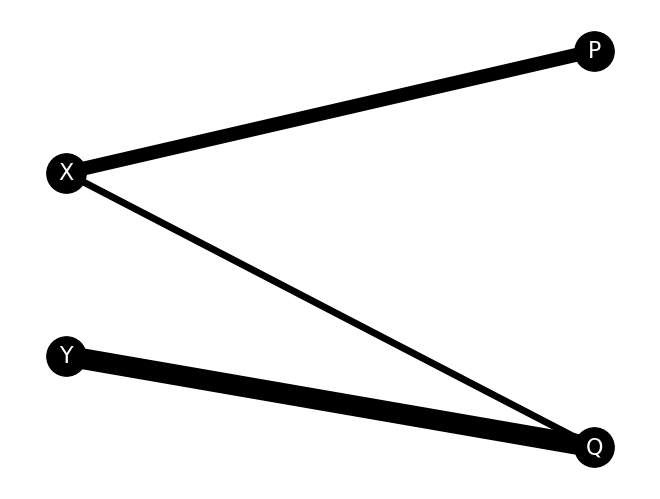

In [39]:
#네트워크 가시화
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 객체 설정
G = nx.Graph()

# 노드 설정
sy = ['X','Y','P','Q']
for i in range(len(sy)):
    G.add_node(sy[i])
#엣지 설정(공장에서 하나 - 대리점에서 하나를 연결)
for i in range(0,2):
    for j in range(2,4):
        G.add_edge(sy[i], sy[j])
        
# 엣지 가중치 리스트화
size = 0.5 # 가중치 사이즈 축소

sy2 = []
for i in range(len(tc3.index)):
    sy2.append(tc3['ValX'].iloc[i] * size)
    
# 좌표 설정(정보가 없어 내가 임의 설정)

pos = {}
pos['X'] = (0, 0.9)
pos['Y'] = (0, 0.3)
pos['P'] = (0.7,1.3)
pos['Q'] = (0.7,0)

#그리기
nx.draw(G, pos, with_labels=True, font_size = 16, node_size = 800, node_color = 'k', font_color = 'w', width = sy2) # 가중치는 width옵션으로 지정
plt.show()

### 최적 생산량 검증

In [40]:
supply_cost

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,1,A,0,inf,1.0,v000022,20.0
3,X,1,B,0,inf,1.0,v000023,10.0
4,Y,1,A,0,10.0,3.0,v000024,10.0
6,Y,1,A,0,inf,5.0,v000025,0.0
7,Y,1,B,0,inf,3.0,v000026,20.0


In [41]:
# 이 최적의 생산량(ValY)일 때 총 생산비용은? -> ValY와 생산비 곱
product_cost = 0
for i in range(len(supply_cost.index)):
    product_cost += supply_cost['생산비'].iloc[i]*supply_cost['ValY'].iloc[i]
    
print(product_cost)

120.0
